# Формуллировка

Построить интерактивный график зависимости апостериорного распределения параметров от количества параметров модели, sigma (оптимальный параметр априорного распределения для модели), эмпирической дисперсии параметров. Для каждого значения количества параметров в интерактивном графике построить поверхность с осями: sigma^2, эмпирическая дисперсия параметров, апостериорная вероятность параметров. Цвет каждой поверхности задать зависимым от Evidence. Модель: логистическая регрессия на полиномах различных степеней от одного признака. Выборка: произвольная (допускается использование синтетических выборок или использование одного наиболее значимого параметра на одном из стандартных датасетов sklearn). Априорное распределение параметров: нормальное распределение со скалярным параметром дисперсии дисперсией (N(0, sigma^2 * I)).

## Пошаговые действия

***1) Поймем, что у нас за модель.*** 

Просто лог регрессия это модель следующего вида $$\mathbf{P}(y=1) = f(z), \mathbf{P}(y=0) = 1-f(z)$$
, где $z = \sum\theta_{i}x_{i}$, $f(x) = \frac{1}{1+\exp(-x)}$. Размерность параметра соответсвенно равна размерности $x+1$.

Однако в нашем лучае, модель на полиномах, но взамен от одного признака. Тогда при тех же обозначениях, она будет выгдядеть немного иначе. 
$$\mathbf{P}(y=1) = f(\theta^{T}poly(x, deg)), \mathbf{P}(y=0) = 1-f(\theta^{T}poly(x, deg))$$
, где $poly(x, deg) = (x^0, x^1, ... , x^{deg})$. $x$ при этом одномерный, а размерность параметра уже равна $deg+1$.

***Вывод:*** Нашу задачу можно оптимизировать и рассматривать как обычную логистическую регрессию просто с предобработанными данными.

***2) Что происходи в байесовском выводе.***
Как мы помним для первого шага байесовского вывода нам необходимо максимизировать числитель дроби: $$\frac{L(D|\omega)p(\omega|h)}{\int_\omega p(D|h)}$$

В лсучае простой лог регрессия это просто максимизация правдоподобия:
$$argmax \sum y^{(i)} \ln f(\theta^Tx^{(i)}) +  (1 - y^{(i)})(1 - \ln f(\theta^Tx^{(i)}))$$

В нашем же случае мы полагаем, что $\omega \sim N(0, \sigma^2I)$ мы получаем чуть более сложную формулу, но которая удачно преобразуется:
$$argmax ( \prod \mathbf{P}(y^{(i)}|x^{(i)}, \omega))p(\omega) = $$ 
$$ = argmax ( \sum \ln (\mathbf{P}(y^{(i)}|x^{(i)}, \omega)))+ \ln \mathbf{P}(\omega) = $$ $$ = argmax ( \sum \ln (\mathbf{P}(y^{(i)}|x^{(i)}, \omega)))+ \ln \frac{1}{(2\pi)^{deg/2}\sigma^{deg}} - \frac{1}{2}\omega^T\frac{1}{\sigma^2}I\omega =$$
$$ = argmax ( \sum \ln (\mathbf{P}(y^{(i)}|x^{(i)}, \omega))) - \frac{1}{2\sigma^2}\| \omega \|^2$$

Т е в итоге мы получаем ту же задачу, только прибавляем еще $l_2$ норму. Соответсвено мы получили $l_2$ - регуляризацию. 

***Вывод:*** Для поиска апостериорной вероятности параметров и эмперической дисперсии параметров используем обычный склерновский оптимизатор для логрега с $l_2$ регуляризацией и константой $\frac{1}{2\sigma^2}$. А потом подставляем $\omega$ в соответсвующие формулы.

***3)Поиск evidence***

Для цвета поверхности нам необходимо определить знаменатель дроби (качество модели)
$$\frac{L(D|\omega)p(\omega|h)}{\int_\omega p(D|h)}$$
Однако, что при подсчете для линейного случая (аналитическая формула), что при приближением Лапласа на $y$ вводится условие о его нормальность. В то время как у нас $y \sim Bern(f(\theta^{T}poly(x, deg)))$ Можно попытаться чесно подставить бернуллевское распределение в интеграл, и взять первую производную, чтобы повторить метод из приближения лапласом. Однако у меня ничего не сокращается, и фишкас тем, что под интегралос получается ненормированное распределение уходит. 

Аналогичная проблема возникла при поиске аналитического решения в прошлом пункте через MAP так как бернуллевское и нормальное распределения не сопряжены. Соответсвенно сразу получить аргмакс произведения не получилось.

In [173]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

In [174]:
#для теста возмем обычные ирисы фишера и проекцию на первую координату
data = load_iris()

X = data.data
X = X[:,[0]]
y = data.target

In [175]:
#переводим элемент выборки в многочлен
def poly(X, deg):
    p = PolynomialFeatures(degree=deg)
    return p.fit_transform(X)

In [176]:
#обучаем модель согласно константам выведенным выше
def logreg(X, y, deg, sigma):
    model = LogisticRegression(penalty='l2', random_state=17, 
                               max_iter=1000, C=1/(2*sigma**2))
    model.fit(poly(X, deg), y)
    return model

In [177]:
def get_evidence():
    #положим мы научились искать evidence
    return 1

In [178]:
#подставляем сигмоиду из определения вначале текста
def sigmoid(x):
    return 1/(1+np.e**(-x))

In [179]:
#правдоподобие берем из второго пункта
def likleyhood(X, y, w):
    X_poly = poly(X, len(w)-1)
    X_poly_w = X_poly@w.T
    X_poly_w_sig = sigmoid(X_poly_w)
    return np.prod(X_poly_w_sig[y==1])+np.prod((1-X_poly_w_sig)[(1-y)==1])

In [180]:
def density(w, sigma):
    return ((2*np.pi)**(len(w)/2) * sigma**len(w))**(-1) * np.e**(-1/2*sum(w**2)/sigma**2)

In [181]:
def apost_prob(X, w, y, deg, sigma):
    return likleyhood(X, y, w)*density(w, sigma)

***Посмотрим на изображение:***

In [182]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import *

%matplotlib notebook

<IPython.core.display.Javascript object>


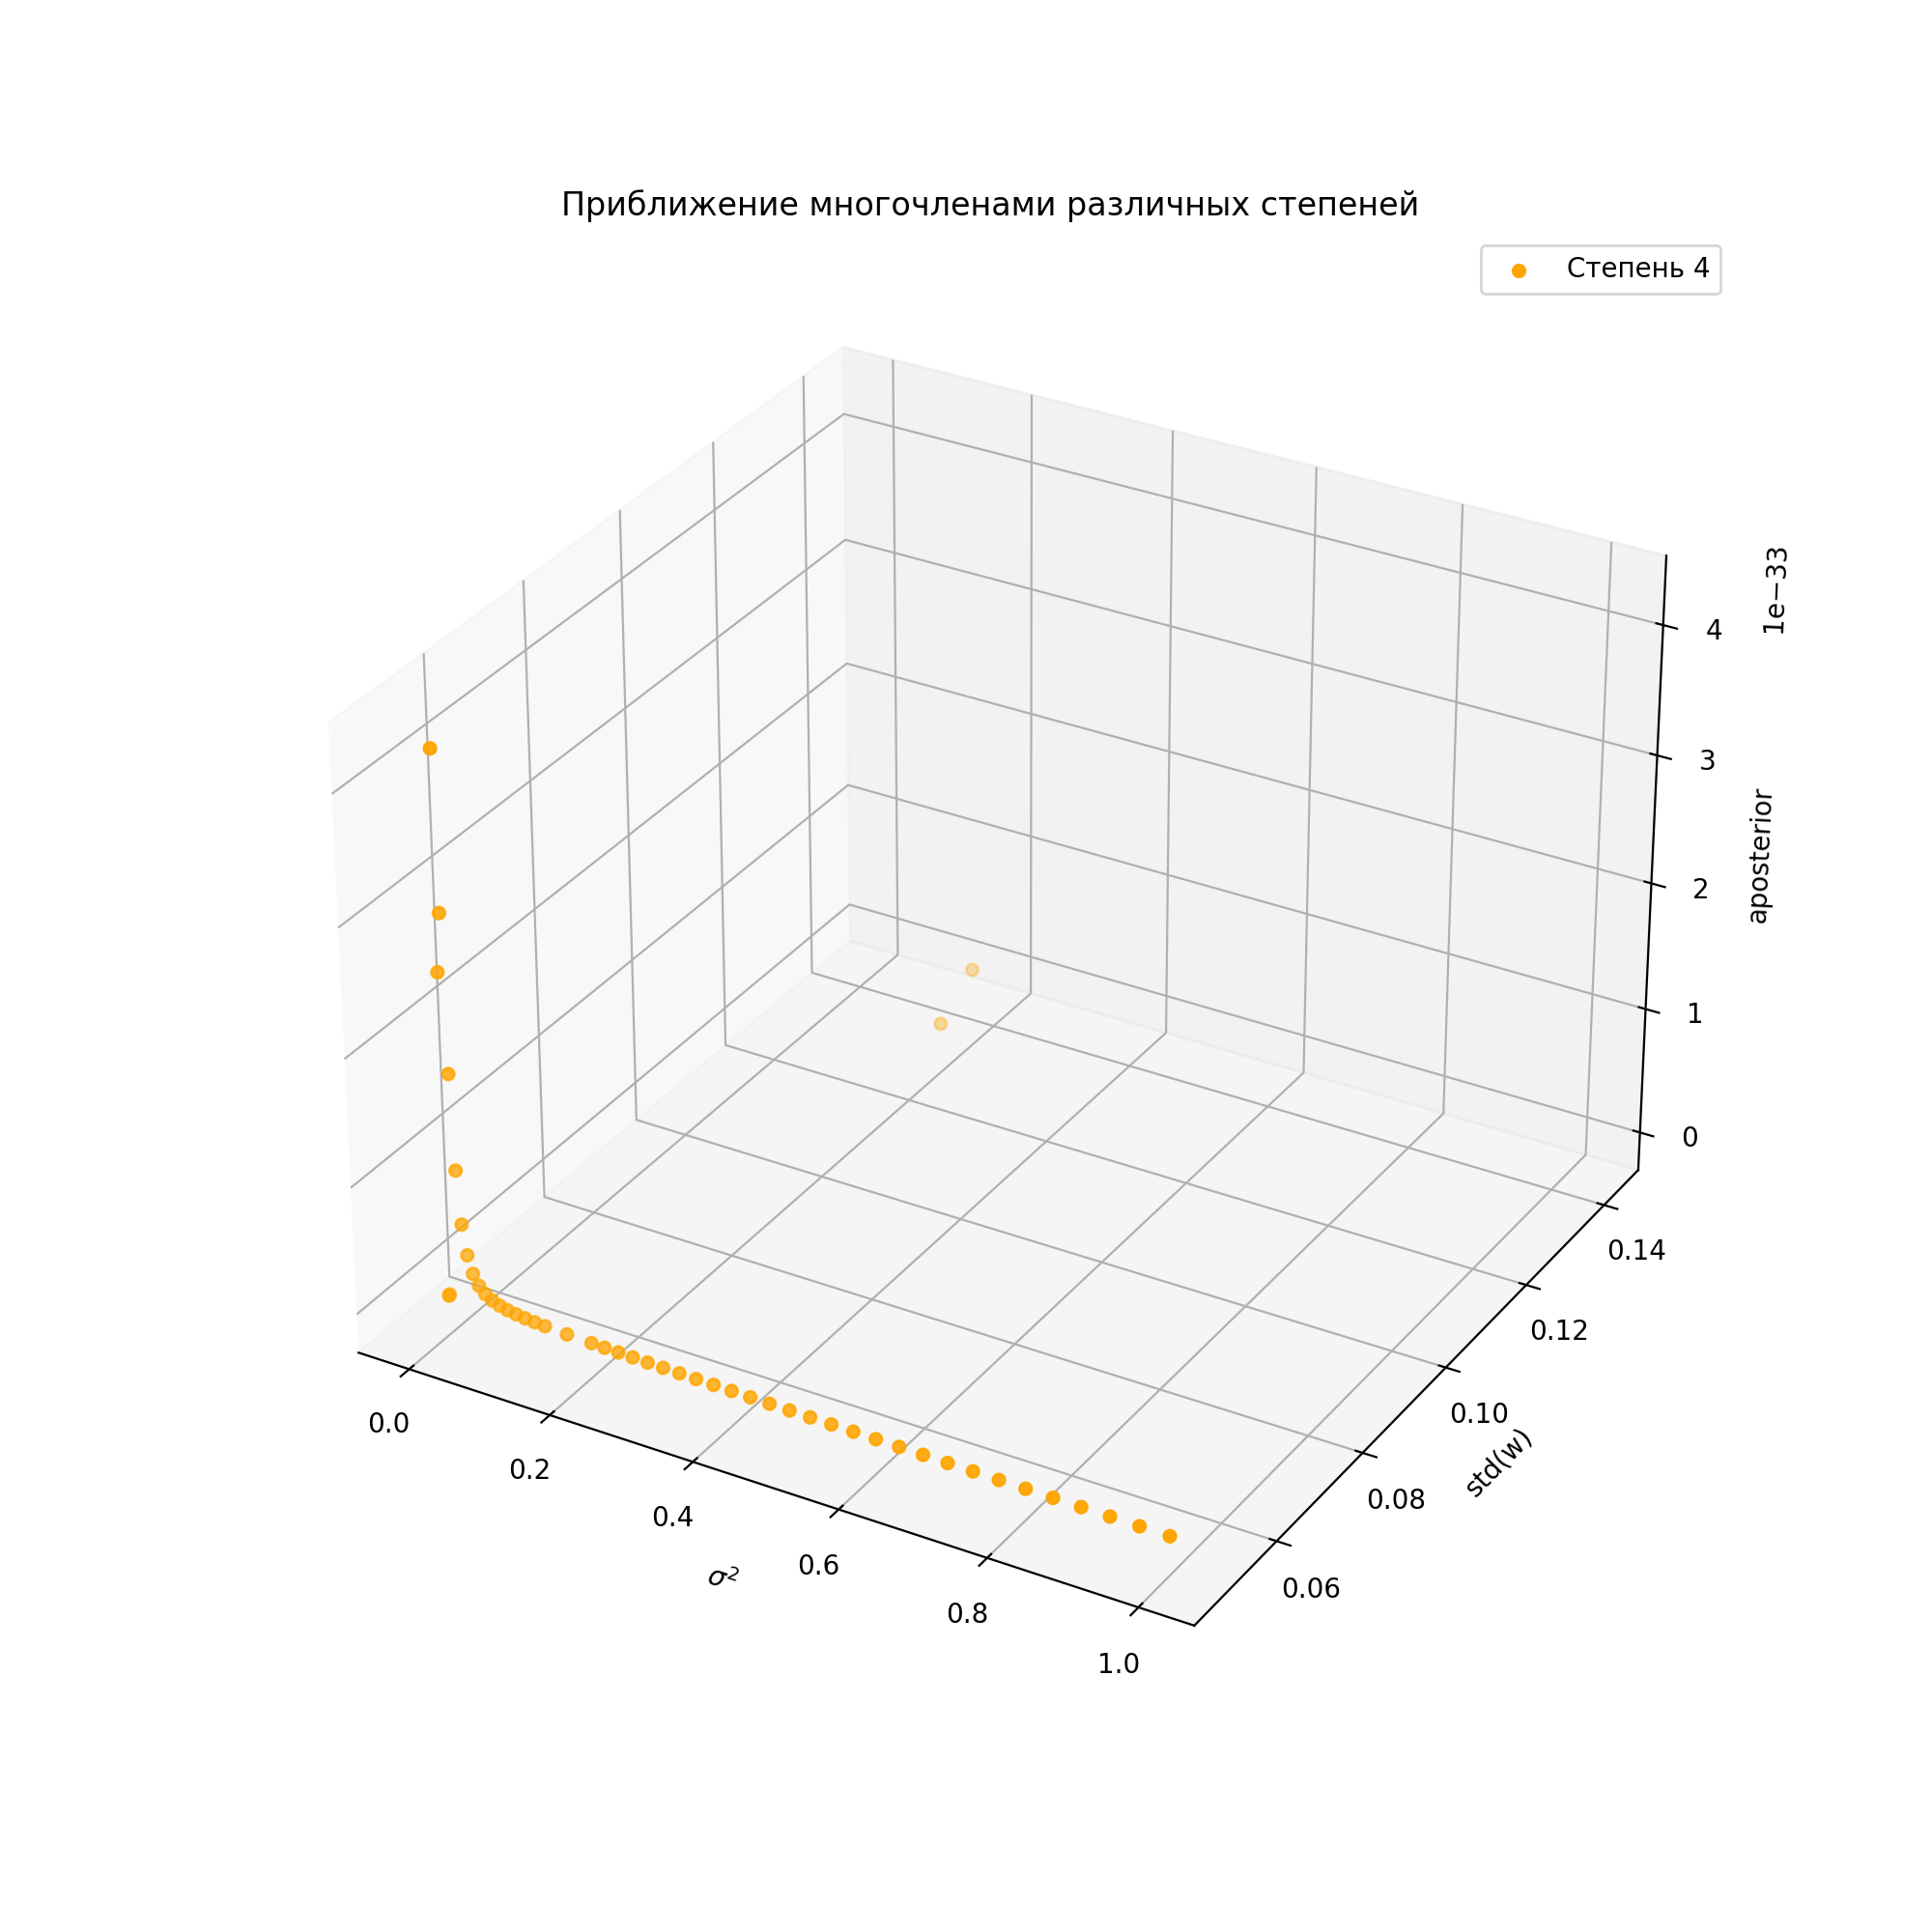

interactive(children=(IntSlider(value=4, description='deg', max=6, min=1), Output()), _dom_classes=('widget-in…

In [183]:
sigma = np.linspace(0.01, 1, 50)
сolours = [_ , "red", "green", "blue", 
           "orange", "black", "yellow"]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

X_plot = sigma**2

ax.set_zlabel('aposterior')
ax.set_xlabel('$\sigma^2$')
ax.set_ylabel('std(w)')

def update(deg=4):
    Y_plot = []
    Z_plot = []
    for i in tqdm(X_plot):
        w = logreg(X_train, y_train, deg, i**(1/2)).coef_[0]
        Y_plot.append(np.std(w))
        Z_plot.append(apost_prob(X_train, w, y_train, deg, i**(1/2)))
    
    ax.set_title("Приближение многочленами различных степеней")
    ax.scatter(X_plot, Y_plot, Z_plot, 
               label="Cтепень {}".format(deg),
               c=сolours[deg])  
    
    ax.legend()

fig.canvas.mpl_connect('draw_event', update)    
interact(update, deg=(1,6,1));

***Вывод:*** Как видим почти в любой степени при уменьшении дисперсии или при средних дисперсиях мы получаем большее значение максимума MAP. А так же при уменьшении степени приближения. Если бы при этом еще evidence рос то мы бы могли достаточно хорошо определить модель.